<a href="https://maestriasydiplomados.tec.mx/posgrados/maestria-en-inteligencia-artificial-aplicada"><img src="logo_MR4010.png"></a>
<h1> <div align="center"> Dr. David Antonio-Torres</div> </h1>

# DETECCION DE VEHICULOS CON HOG Y SVM
### www.gti.ssr.upm.es/data/Vehicle_database.html

# Se cargan las bibliotecas necesarias

In [77]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob
import os
import pandas as pd
from lxml import etree
from tqdm import tqdm


# Se importan los dos datasets 
### https://docs.python.org/3/library/glob.html

In [ ]:
pedestrian_imgs_path = "data/train/JPEGImages/*.jpg"
pedestrian_xmls_path = "data/train/Annotations/*.xml"

nrows = 5
ncols = 2
figsize=(12, 18)

In [ ]:
def read_images(path_images = []):
    images = []
    for path_image in path_images:
        images.append(cv2.imread(path_image))
    return images

def convert_RGB2GRAY(color_images = []):
    images = []
    for color_image in color_images:
        images.append(cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY))
    return images


extract_hog = lambda img: hog(img,
                       orientations = 11,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

def process_hog_imgs(df):
    df["features"] = None
    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_path = row["filename"]
        img_color = mpimg.imread(img_path)
        img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
        
        if img_gray is None:
            print(f"coud not read {img_path}")
            continue
        
        features, _ = extract_hog(img_gray)
        df.at[i, "features"] = features
        
    df.to_pickle("data/hog_pedestrians_dataset.pkl")
    
is_pedestrian = lambda x: "pedestrian" if x == 1 else "not pedestrian"

def show_predictions(image_ids, y_true, y_pred, n=10):
    imgs = []
    labels = []
    
    for i in range(n):
        image_path = image_ids[i]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        imgs.append(img)
        labels.append(f"Image: {image_path}\nTrue: {is_pedestrian(y_true[i])}\nPred: {is_pedestrian(y_pred[i])}")
        
    plot_images(images=imgs, labels=labels, nrows=nrows, ncols=ncols, figsize=figsize )
        


def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray", hideAxis=True):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """
    if len(images) > 1:
        # set the subplots
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        # Iterate over each axis defined in M*N as flat
        for i, ax in enumerate(axs.flat):
            
            # validates that the dimensions of axs fits with images array parameter
            if i < len(images):
                # plot the image
                ax.imshow(images[i], cmap=cmap)
                # if there are labels defined then set a title
                if len(labels) > 0:
                    ax.set_title(labels[i])
                # dont show the axis ticks
                if hideAxis:
                    ax.axis("off")
            else:
                # dont show an empty plot
                ax.axis("off")
    else:
        plt.figure(figsize=figsize)
        plt.imshow(images[0], cmap=cmap)
        if len(labels) > 0:
            # Display width and height in the title
            plt.title(labels[0])  
        if hideAxis:
            plt.xticks([])
            plt.yticks([])
    # fits the plots
    plt.tight_layout()
    plt.show()

In [ ]:
class Pedestrians:
    
    def __init__(self, image_file_path, xml_file_path):
        img_paths, xml_paths = self.get_file_paths(image_file_path=image_file_path, xml_file_path=xml_file_path)   
        self.get_pedestrians(img_paths=img_paths, xml_paths=xml_paths)
        

    def get_file_paths(self, image_file_path, xml_file_path):
        image_files = sorted(glob.glob(image_file_path))
        xml_files = sorted(glob.glob(xml_file_path))
        
        return image_files, xml_files
    
    def get_pedestrians(self, img_paths, xml_paths):
        output_dir = "data/pedestrian_crops"
        dataset_entries = []
        
        for (img_path, xml_path) in zip(img_paths, xml_paths):
            tree = etree.parse(xml_path)
            root = tree.getroot()
            image = cv2.imread(img_path)
            image_filename = root.find("filename").text
            
            for idx, obj in enumerate(root.findall("object")):
                label = obj.find("name").text
                
                bbox = obj.find("bndbox")
                xmin = int(float(bbox.find("xmin").text))
                ymin = int(float(bbox.find("ymin").text))
                xmax = int(float(bbox.find("xmax").text))
                ymax = int(float(bbox.find("ymax").text))
                
                # crop and save the image
                crop = image[ymin: ymax, xmin: xmax]
                crop = cv2.resize(crop, (64,64))  
                
                crop_filename = f"{os.path.splitext(image_filename)[0]}_{idx}.jpg"
                # plt.imshow(crop)
                # plt.title(crop_filename)
                # plt.show()
                
                crop_filename = os.path.join(output_dir, crop_filename)
                cv2.imwrite(crop_filename, crop)
                
                dataset_entries.append({
                    "filename": crop_filename,
                    "label": 1 if label == "person" else 0
                })
        
        df = pd.DataFrame(dataset_entries)
        df.to_csv("data/pedestrians_dataset.csv", index=False)
        print("Pedestrians dataset generated")
            
    

In [ ]:
pedestrian = Pedestrians(image_file_path=pedestrian_imgs_path, xml_file_path=pedestrian_xmls_path)

Pedestrians dataset generated


In [ ]:
pedestrians_df = pd.read_csv("data/pedestrians_dataset.csv")
pedestrians_df.head()

,filename,label
0,data/pedestrian_crops/image (1)_0.jpg,1
1,data/pedestrian_crops/image (10)_0.jpg,1
2,data/pedestrian_crops/image (100)_0.jpg,1
3,data/pedestrian_crops/image (100)_1.jpg,1
4,data/pedestrian_crops/image (101)_0.jpg,1


In [14]:
pedestrians_df.count()

filename    2066
label       2066
dtype: int64

In [13]:
pedestrians_df["label"].value_counts()

label
1    1106
0     960
Name: count, dtype: int64

# Se muestra una imagen con vehículo

In [21]:
random_pedestrians = pedestrians_df.sample(n=10)
random_pedestrians.head()

,filename,label
1255,data/pedestrian_crops/image (624)_4.jpg,0
97,data/pedestrian_crops/image (138)_1.jpg,1
291,data/pedestrian_crops/image (218)_1.jpg,1
354,data/pedestrian_crops/image (244)_2.jpg,1
1448,data/pedestrian_crops/image (690)_1.jpg,0


In [ ]:
tmp_pedestrian_path_imgs= random_pedestrians.get("filename").to_list()
tmp_pedestrian_labels = random_pedestrians.get("label").apply(lambda x: "Pedestrian" if x == 1 else "Not pedestrian").to_list()

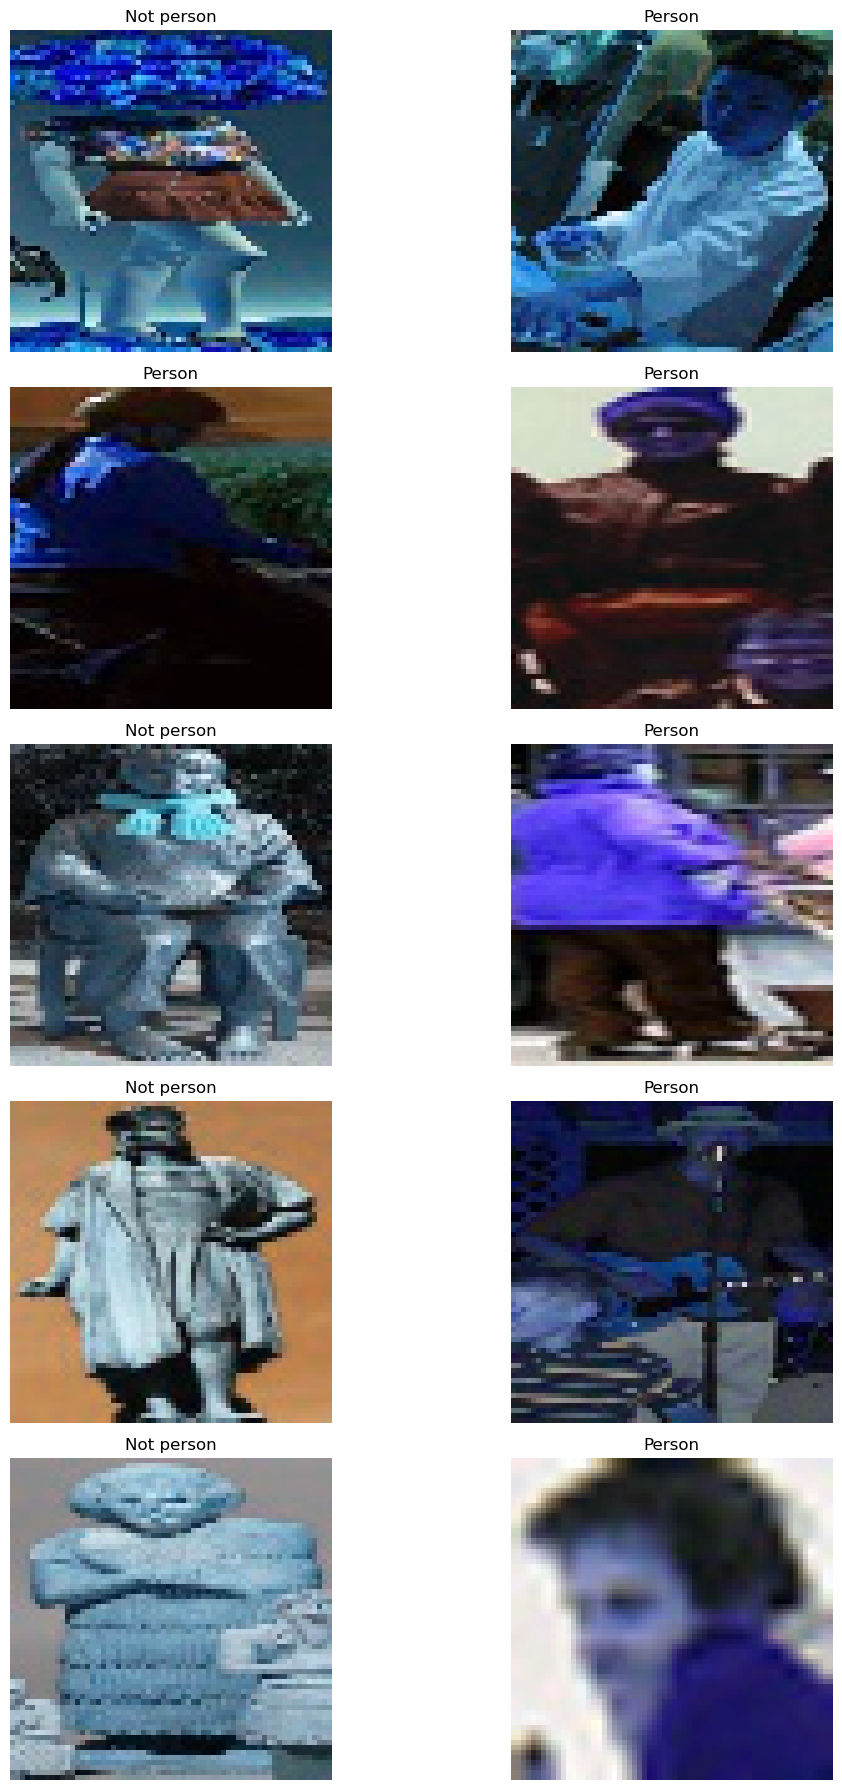

In [ ]:
tmp_pedestrian_imgs = read_images(tmp_pedestrian_path_imgs)
plot_images(images=tmp_pedestrian_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# Para fines de demostración se calcula el HOG de la imagen

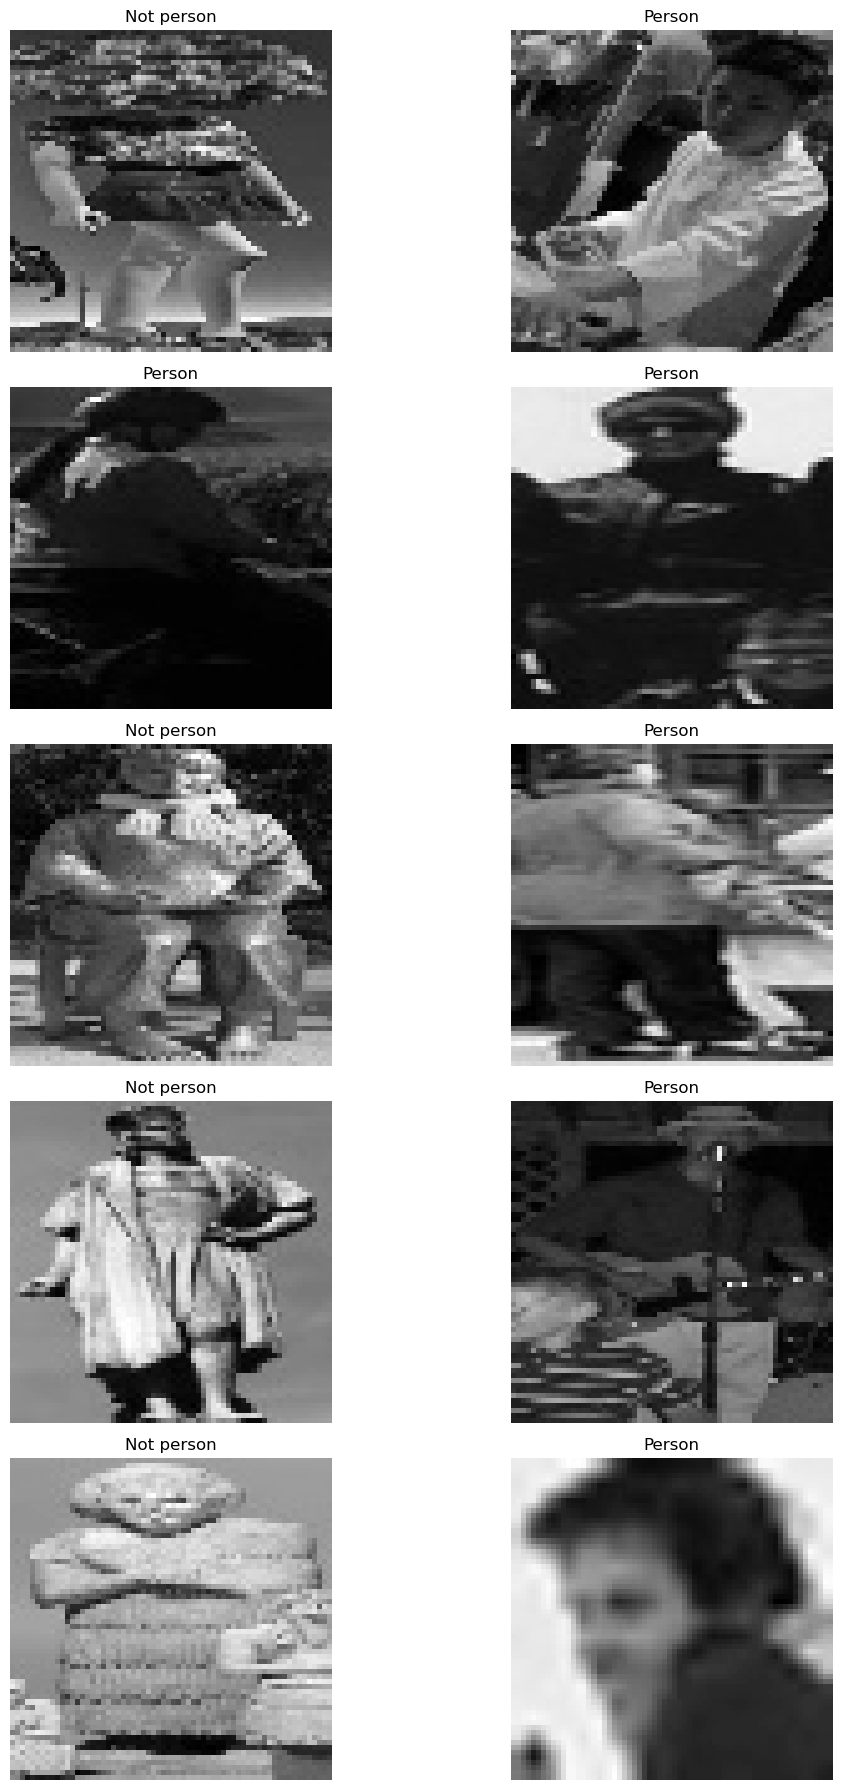

In [45]:
imgs_gray = convert_RGB2GRAY(color_images=tmp_pedestrian_imgs)
plot_images(images=imgs_gray, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

In [ ]:
hog_features = []

for gray_img in imgs_gray:
    features,hog_img = extract_hog(gray_img)
    hog_features.append({
        "features": features,
        "hog_img": hog_img
    })


In [72]:
hog_imgs = []
for idx, hog_feature in enumerate(hog_features, 0):
    hog_imgs.append(hog_feature["hog_img"])
    print(f"IMAGE_{idx}.- FEATURE SHAPE -> {hog_feature['features'].shape} [*] IMG SHAPE -> {hog_feature['hog_img'].shape}")

IMAGE_0.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_1.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_2.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_3.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_4.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_5.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_6.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_7.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_8.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_9.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)


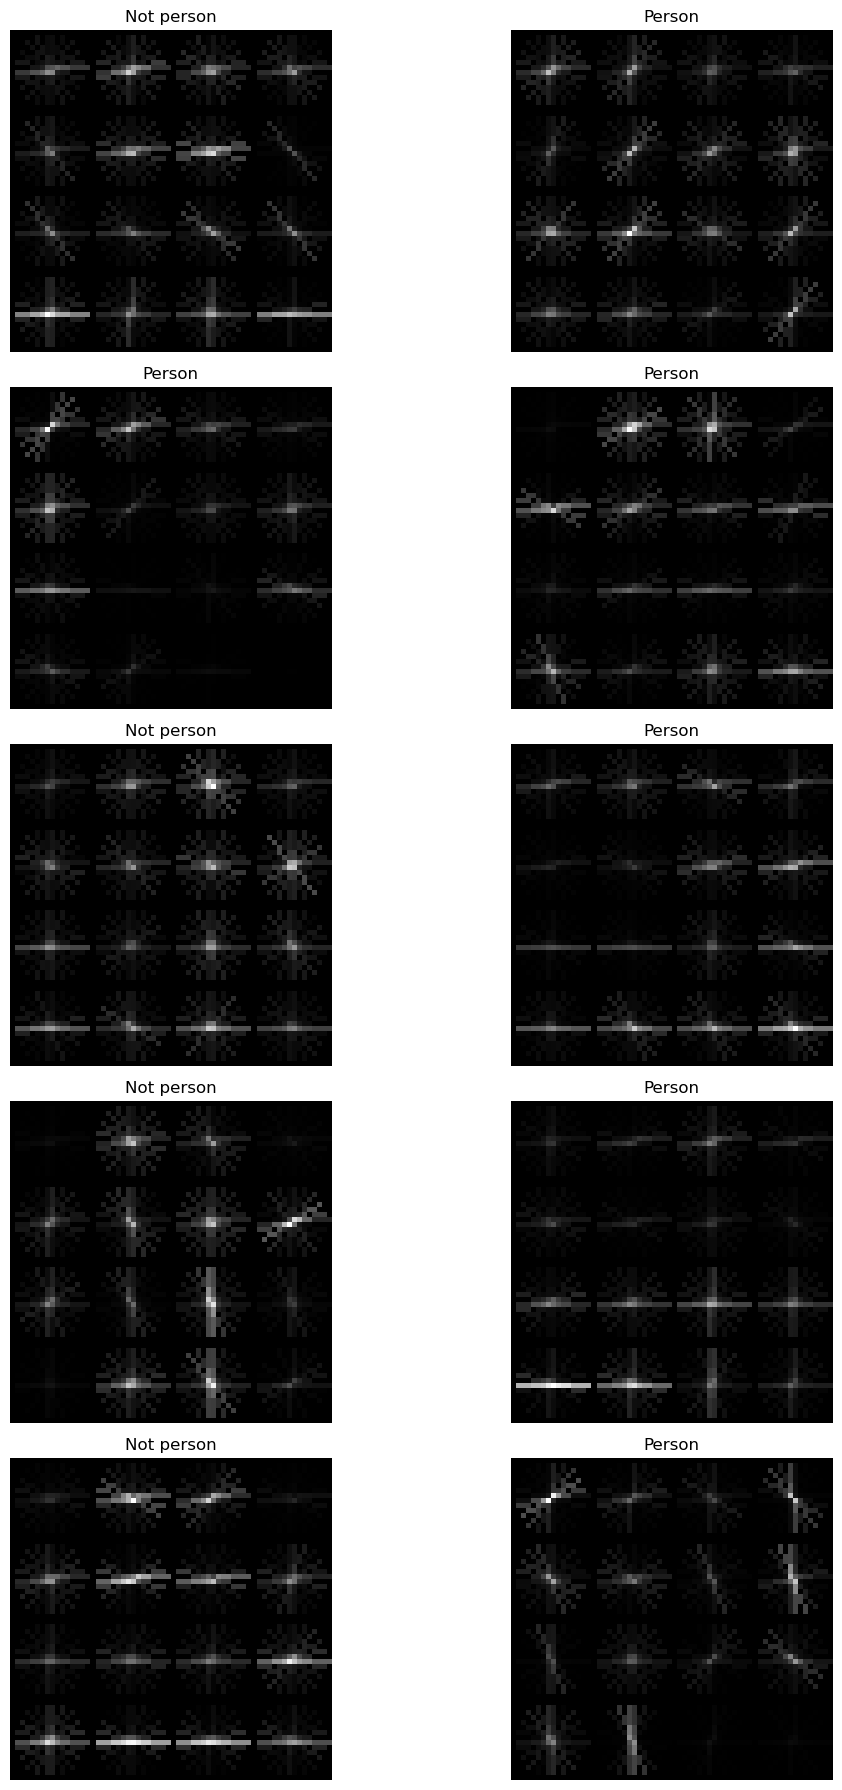

In [73]:
plot_images(images=hog_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# Se extraen las features del HOG para ambos tipos de datos

In [78]:
process_hog_imgs(pedestrians_df)

100%|██████████| 2066/2066 [00:08<00:00, 230.66it/s]


In [ ]:
df = pd.read_pickle("data/hog_pedestrians_dataset.pkl")
df.head()

,filename,label,features
0,data/pedestrian_crops/image (1)_0.jpg,1,"[0.17621226757272837, 0.11970332756318078, 0.2..."
1,data/pedestrian_crops/image (10)_0.jpg,1,"[0.17434682525850692, 0.16302948567861925, 0.1..."
2,data/pedestrian_crops/image (100)_0.jpg,1,"[0.14285142494707212, 0.038435981037694036, 0...."
3,data/pedestrian_crops/image (100)_1.jpg,1,"[0.09548145701380828, 0.025004826031810708, 0...."
4,data/pedestrian_crops/image (101)_0.jpg,1,"[0.2433784390606614, 0.010232653819074329, 0.0..."


In [116]:
X = df["features"].tolist()
y = np.array(df["label"].tolist())
X = np.vstack(X).astype(np.float64)
image_ids = df["filename"].tolist()

In [117]:
print(X.shape)
print(y.shape)
print(len(image_ids))

(2066, 396)
(2066,)
2066


# Se generan los datos de entrenamiento y de prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, image_ids, test_size = 0.3, random_state = 42)

In [120]:
X_train.shape

(1446, 396)

In [121]:
X_test.shape

(620, 396)

In [122]:
id_train[:5]

['data/pedestrian_crops/image (736)_4.jpg',
 'data/pedestrian_crops/image (485)_1.jpg',
 'data/pedestrian_crops/image (519)_1.jpg',
 'data/pedestrian_crops/image (225)_1.jpg',
 'data/pedestrian_crops/image (50)_0.jpg']

In [123]:
id_test[:5]

['data/pedestrian_crops/image (710)_0.jpg',
 'data/pedestrian_crops/image (915)_2.jpg',
 'data/pedestrian_crops/image (647)_0.jpg',
 'data/pedestrian_crops/image (846)_1.jpg',
 'data/pedestrian_crops/image (113)_0.jpg']

# Se importa el Clasificador y se entrena

In [124]:
#from sklearn.svm import LinearSVC

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [125]:
y_predict = svc_model.predict(X_test)

<Axes: >

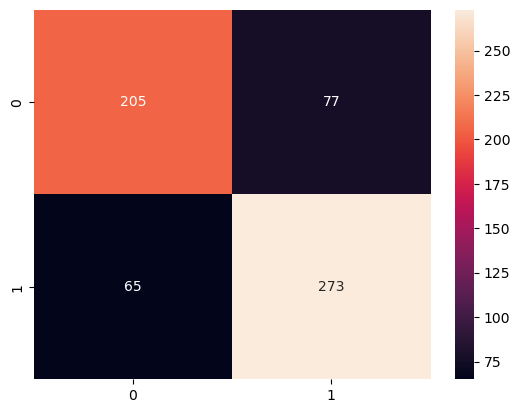

In [126]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")

In [127]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       282
           1       0.78      0.81      0.79       338

    accuracy                           0.77       620
   macro avg       0.77      0.77      0.77       620
weighted avg       0.77      0.77      0.77       620



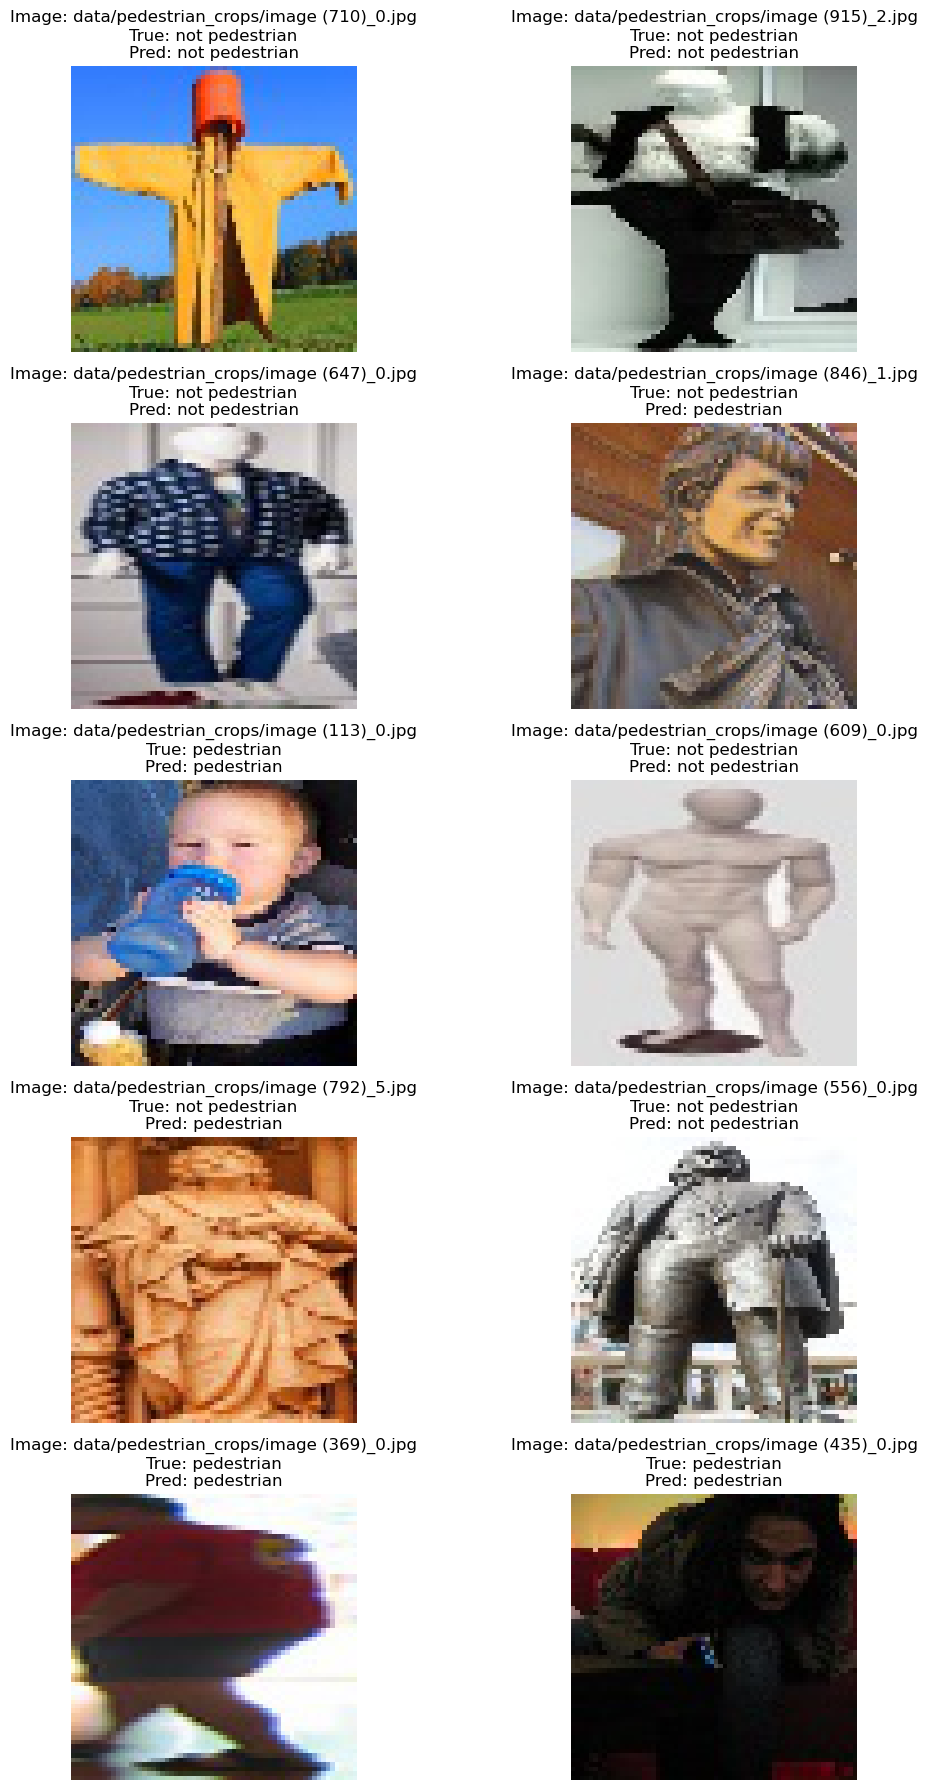

In [135]:
show_predictions(image_ids=id_test, y_true= y_test, y_pred=y_predict)

# GridSearchCV

In [137]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [138]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.528 total time=   0.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.648 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.654 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.647 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.661 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.531 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [139]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [140]:
grid.best_estimator_

SVC(C=10, gamma=1)

In [141]:
grid_predictions = grid.predict(X_test)

<Axes: >

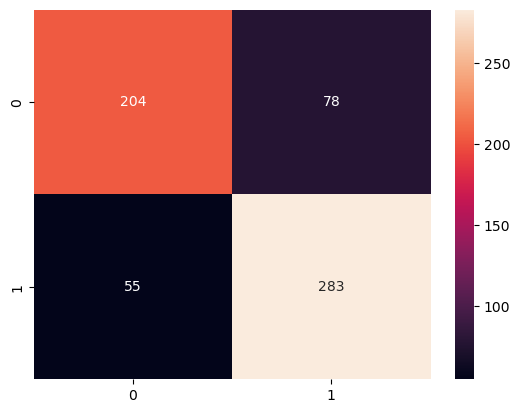

In [142]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [143]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       282
           1       0.78      0.84      0.81       338

    accuracy                           0.79       620
   macro avg       0.79      0.78      0.78       620
weighted avg       0.79      0.79      0.78       620



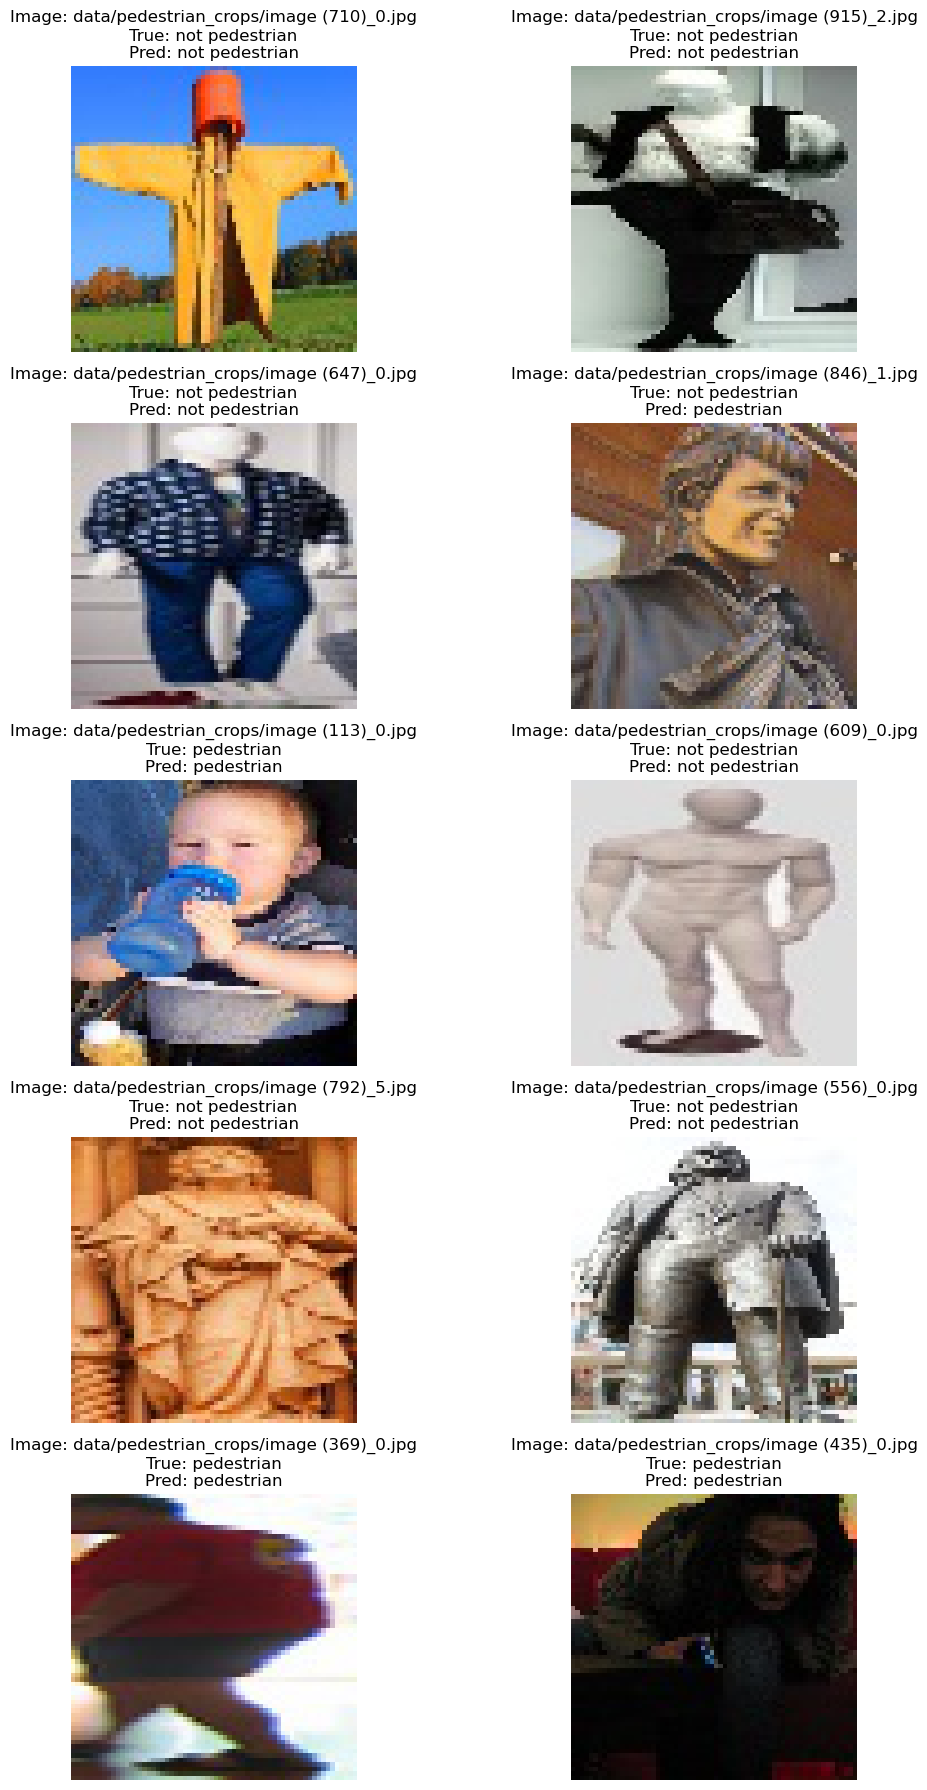

In [144]:
show_predictions(image_ids=id_test, y_true= y_test, y_pred=grid_predictions)